Import needed libraries and the dataset csv

(19980, 21)

Clean up the dataset

In [151]:
import pandas as pd
import numpy as np
from pathlib import Path

# Build path to file
# Selects current working directory
cwd = Path.cwd()
csv_path = 'data/dataframe.csv'
csv_cleaned_path = 'output/dataframe_cleaned.csv'
src_path = (cwd / csv_path).resolve()
out_path = (cwd / csv_cleaned_path).resolve()

# Read the csv
csv = pd.read_csv(src_path, index_col=0)
csv.shape

# Removing unneeded data
# dropping empty rows
csv = csv.dropna(how='all')
# dropping duplicates (if any)
csv = csv.drop_duplicates()
# Dropping house and appartment groups since they have no data
csv = csv.drop(csv[(csv['property_type'] == 'HOUSE_GROUP') | (csv['property_type'] == 'APARTMENT_GROUP')].index)
# Drop rows without a price property
csv = csv.drop(csv[pd.isna(csv['price']) == True].index)
# Drop rows with 0 rooms
csv = csv.drop(csv[csv['number_rooms'] == 0].index)
# Drop rows without a living area property
csv = csv.drop(csv[pd.isna(csv['living_area']) == True].index)
# Assuming that a NaN value or 0 means no kitchen installed, replacing the strings with integers
# 0 = NOT_INSTALLED, 0.5 = SEMI_EQUIPPED, 1 = INSTALLED, 2 = HYPER_EQUIPPED
csv['kitchen'] = csv['kitchen'].fillna('NOT_INSTALLED')
csv['kitchen'] = csv['kitchen'].replace('0', 'NOT_INSTALLED')
csv['kitchen'] = csv['kitchen'].replace(0, 'NOT_INSTALLED')
"""csv['kitchen'] = csv['kitchen'].replace('USA_UNINSTALLED', 0)
csv['kitchen'] = csv['kitchen'].replace('SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('USA_SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('USA_INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('HYPER_EQUIPPED', 2)
csv['kitchen'] = csv['kitchen'].replace('USA_HYPER_EQUIPPED', 2)"""
# Filling empty values and changing true/false to 1/0
csv['furnished'] = csv['furnished'].fillna(0)
csv['furnished'] = csv['furnished'].replace(False, 0)
csv['furnished'] = csv['furnished'].replace(True, 1)
# Assuming that a NaN value,0 or -1 means no fireplace installed
csv['fireplace'] = csv['fireplace'].fillna(0)
csv['fireplace'] = csv['fireplace'].replace(-1, 0)
# Filling empty values and changing true/false to 1/0
csv['terrace'] = csv['terrace'].fillna(0)
csv['terrace'] = csv['terrace'].replace(False, 0)
csv['terrace'] = csv['terrace'].replace(True, 1)
# Assuming the surface area = living area in case of apartments
to_replace = csv[((csv['surface_land'] == 'UNKNOWN')|(pd.isna(csv['surface_land']) == True)) & (csv['property_type'] == 'APARTMENT')]
to_replace = to_replace.reset_index()
# Looping through rows to replace the values
for index, row in to_replace.iterrows():
    csv.loc[row['index'], 'surface_land'] = row['living_area']
# Dropping rows with no surface area 
csv = csv.drop(csv[(csv['surface_land'] == 'UNKNOWN') | (pd.isna(csv['surface_land']) == True) | (csv['surface_land'] == 0)].index)
# Dropping rows with no facade info
csv = csv.drop(csv[(csv['number_facades'] == 'UNKNOWN') | (pd.isna(csv['number_facades']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['swimming_pool'] = csv['swimming_pool'].fillna(0)
csv['swimming_pool'] = csv['swimming_pool'].replace(False, 0)
csv['swimming_pool'] = csv['swimming_pool'].replace(True, 1)
csv = csv.drop(csv[(csv['building_state'] == 'UNKNOWN') | (pd.isna(csv['building_state']) == True)].index)

# If terrace = 1 but no terrace_area present, drop the row
csv = csv.drop(csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['terrace_area'] = csv['terrace_area'].fillna(0)
# If garden = 1 but no garden_area present, drop the row
csv = csv.drop(csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == True)].index)
# No garden, filling empty values
csv['garden'] = csv['garden'].fillna(0)
csv['garden'] = csv['garden'].replace(False, 0)
csv['garden'] = csv['garden'].replace(True, 1)
csv['garden_area'] = csv['garden_area'].fillna(0)

# Change strings to floats in certain columns
csv = csv.drop(csv[(csv['surface_land'] == 0)].index)
csv['surface_land']=csv['surface_land'].astype("float")
csv['number_facades']=csv['number_facades'].astype("float")
csv = csv.drop(csv[csv['zip_code'] == 'UNKNOWN'].index)
csv = csv.drop(csv[pd.isna(csv['region']) == True].index)
csv = csv.drop(csv[pd.isna(csv['province']) == True].index)
csv['zip_code']=csv['zip_code'].astype("str")
csv['ppm'] = csv['price']/csv['surface_land']

# Saves cleaned up csv to 'data/dataframe_cleaned.csv'
csv.to_csv(out_path)
csv.shape


(6890, 22)

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


x = csv[['number_rooms', 'living_area',
       'furnished', 'fireplace', 'terrace', 'terrace_area', 'garden',
       'garden_area', 'surface_land', 'number_facades', 'swimming_pool',
       'property_type', 'property_subtype', 'building_state', 'region', 'zip_code']]

x = pd.get_dummies(data=x, drop_first=True)
X = x.to_numpy()
y = csv['price'].to_numpy()

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().transform(X_test)

regressor = LinearRegression().fit(X_train, y_train)

score_train = regressor.score(X_train, y_train)
score_test = regressor.score(X_test, y_test)

# Get the root mean squared error
y_pred = regressor.predict(X_test)
#rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
rmse= np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

u = ((y_test - y_pred)**2).sum()
v = ((y_test - y.mean())**2).sum()
coef_determination = 1 - u/v

print(f"score train:{score_train}")
print(f"score test:{score_test}")
print(f"rmse:{rmse}")
print(f"coef_determination:{coef_determination}")

(6890, 872)
score:0.6091949667090353
rmse:329609.4893911672
coef_determination:0.6091980788012016


In [146]:
dict_coef = {x.columns[i]: regressor.coef_[i] for i in range(len(x.columns))}

In [147]:
# TODO: zijn er variabelen met extreme coefficienten?
# TODO: welke zijn de hoogste predictions, hoe zien de X eruit daarvoor?
# TODO: normaliseer numerical variabelen tussen 0-1 (StandardScaler())
# TODO: zipcode minder granulair?
dict_coef

{'number_rooms': 60836.14521907644,
 'living_area': 709.5735897748799,
 'furnished': -55643.97440135428,
 'fireplace': 36942.055376217926,
 'terrace': -14228.208046323718,
 'terrace_area': 980.2885838563088,
 'garden': -3504.3899280546466,
 'garden_area': 15.590194084506948,
 'surface_land': 13.991499021241907,
 'number_facades': 38376.8129309701,
 'swimming_pool': 381763.3548386834,
 'property_type_HOUSE': -5424235275645.153,
 'property_subtype_APARTMENT_BLOCK': 5424235358282.849,
 'property_subtype_BUNGALOW': 5424235381875.592,
 'property_subtype_CASTLE': 5424231920664.941,
 'property_subtype_CHALET': 5424235389770.8,
 'property_subtype_COUNTRY_COTTAGE': 5424235433109.354,
 'property_subtype_DUPLEX': -22121.161496138026,
 'property_subtype_EXCEPTIONAL_PROPERTY': 5424235663827.969,
 'property_subtype_FARMHOUSE': 5424235286281.239,
 'property_subtype_FLAT_STUDIO': 31062.68663559179,
 'property_subtype_GROUND_FLOOR': -20580.215106945252,
 'property_subtype_HOUSE': 5424235359809.111,
 'p

In [57]:
max(y_test)

7500000.0

In [58]:
np.quantile(y_pred, q=0.995)

3070476.7002926962

array([[<Axes: title={'center': '0'}>]], dtype=object)

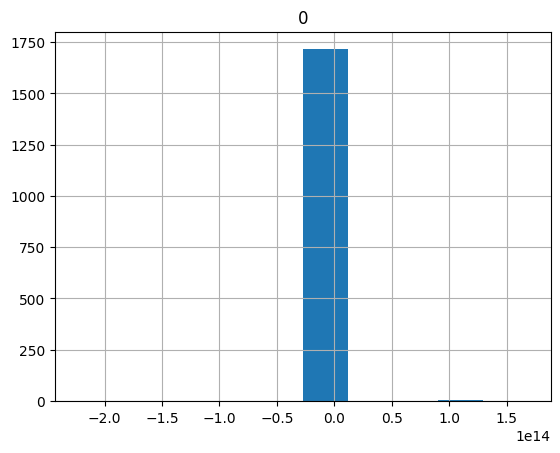

In [91]:
pd.DataFrame(y_pred).hist(bins=10)

In [92]:
x

,number_rooms,living_area,furnished,fireplace,terrace,terrace_area,garden,garden_area,surface_land,number_facades,...,property_subtype_PENTHOUSE,property_subtype_SERVICE_FLAT,property_subtype_TOWN_HOUSE,property_subtype_TRIPLEX,property_subtype_VILLA,building_state_GOOD,building_state_JUST_RENOVATED,building_state_TO_BE_DONE_UP,building_state_TO_RENOVATE,building_state_TO_RESTORE
0,3.0,120.0,0,0.0,1,20.0,1,110.0,227.0,2.0,...,False,False,False,False,False,True,False,False,False,False
2,2.0,235.0,0,0.0,0,0.0,0,0.0,930.0,4.0,...,False,False,False,False,False,False,False,False,False,False
3,6.0,518.0,0,0.0,1,100.0,1,200.0,330.0,2.0,...,False,False,False,False,False,False,False,False,True,False
4,3.0,100.0,0,0.0,0,0.0,0,0.0,265.0,3.0,...,False,False,False,False,False,True,False,False,False,False
6,3.0,140.0,0,0.0,0,0.0,0,0.0,1461.0,4.0,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19963,3.0,98.0,0,0.0,0,0.0,0,0.0,70.0,2.0,...,False,False,False,False,False,True,False,False,False,False
19966,3.0,106.0,0,0.0,1,52.0,0,0.0,205.0,3.0,...,False,False,True,False,False,False,False,False,False,False
19967,3.0,215.0,0,0.0,1,35.0,0,0.0,215.0,2.0,...,False,False,False,False,False,False,True,False,False,False
19968,8.0,278.0,0,0.0,1,40.0,0,0.0,634.0,3.0,...,False,False,False,False,False,True,False,False,False,False


In [22]:
print(sorted(y_pred))

print(sorted(y_test))

[-61886366445902.51, -31277658254030.48, -19273803337542.598, -17963857126009.316, -13354422878847.727, -3959134585710.2183, -1762956329645.6162, -547417.791370795, -487907.9003185489, -277137.1742453072, -261562.38243524812, -226460.6087536075, -222449.59727899812, -190831.57799188874, -179172.30089227937, -173485.1902355411, -147174.25548212312, -139816.73448602937, -134732.45860712312, -133200.95601312898, -130180.40855829499, -128460.65974848054, -124325.32432977937, -103055.13487665437, -102342.32042352937, -100871.17076532624, -100224.33311884187, -97339.08480091393, -96017.13023798249, -95469.44413948612, -88310.35072748445, -83977.28429071687, -79260.52049139683, -74834.47179071687, -70656.98068192787, -69749.7358809762, -62821.71300165437, -57913.06676141999, -57663.44371454499, -52495.78038446687, -48380.813469737535, -48380.813469737535, -45616.47722284577, -43897.30821649812, -42145.30308954499, -39667.336414740304, -36252.09041254304, -32937.80992548249, -32378.89558832429